## Data whitening: Breast Cancer Wisconsin (Diagnostic) Data Set

**Author**: Seddik BELKOURA - 15th May 2018

As a first application example, we here show how the proposed methodology can complement a diagnostic tool in a medical context. We considered the Breast Cancer Wisconsin Data Set, described in [1, 2] and publicly available at [3]. It contains information about 569 patients with breast cancer, each one characterised by 30 features computed from a digitalised image of a fine needle aspirate (FNA) [4] of the breast mass. Each cell nucleus is described by ten features: radius, texture, perimeter, area, smoothness, compactness, concavity, number of concave points, symmetry, and fractal dimension. The average, standard error and average of the three largest values are then calculated for each feature, thus yielding a final set of 30 values for each patient. The task aims at diagnosing the cancer as malign or benign.


*[1] W. N. Street, W. H. Wolberg, O. L. Mangasarian, Nuclear feature extraction for breast tumor diagnosis, in: IS&T/SPIE’s Symposium on Electronic Imaging: Science and Technology, International Society for Optics and Photonics, 1993, pp. 861–870.  
[2] O. L. Mangasarian, W. N. Street, W. H. Wolberg, Breast cancer di- agnosis and prognosis via linear programming, Operations Research 43 (1995) 570–577.  
[3] Wisconsin Breat Cancer data set, http://archive.ics.uci.edu/ml/ datasets/Breast+Cancer+Wisconsin+\%28Diagnostic\%29, 2016.  
[4] M. Wu, D. E. Burstein, Fine needle aspiration, Cancer investigation 22 (2004) 620–628.*

In [4]:
import matplotlib.pylab as plt
import numpy as np
from DataWhitening.datawhitening import Collection_points
from sklearn.ensemble import RandomForestClassifier

## 1. Data Exploration

First tasks consists in loading the data. It is available in the folder Example_data. 

In [2]:
def getData():
    
    import csv
    print("Start loading data...")
    
    with open('example_data/WDBC.txt', 'r') as f:
            reader = csv.reader(f, delimiter = ',')
            rawData = list(reader)    
            rawData = rawData[:]

            cols = ['Mean_radius','Mean_texture','Mean_perimeter','Mean_area','Mean_smoothness','Mean_compactness',
        'Mean_concavity','Mean_concave points','Mean_symmetry','Mean_fractal dimension',
        'radiusSE','textureSE','perimeterSE','areaSE','smoothnessSE','compactnessSE',
        'concavitySE','concave pointsSE','symmetrySE','fractal dimensionSE',
        'Worst_radius','Worst_texture','Worst_perimeter','Worst_area','Worst_smoothness','Worst_compactness',
        'Worst_concavity','Worst_concave points','Worst_symmetry','Worst_fractal dimension',
        ]
            featureTitles = cols + ['diagnosis']
            alldata = np.zeros(( len(rawData) , len(featureTitles) ))
            for n in range(len(rawData)):  
                
                alldata[n,:-1] = list(map(float,rawData[n][2:]))
                
                if rawData[n][1] == 'M':
                    alldata[n,-1] = 1
                else:
                    alldata[n,-1] = 0
    
    print("Data ready.")

    return(alldata, featureTitles)


In [5]:
alldata, f = getData()

Start loading data...
Data ready.


The way we uploaded the data:
* label 0 means Begnign cell 
* Label 1 means a Malign cell 

We can have a look at the difference between Malign and Begnign cells along two randomly chosen dimensions.

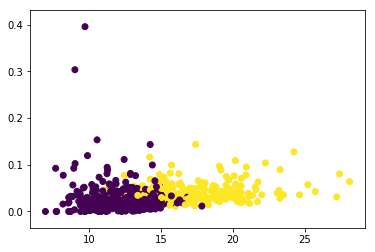

In [6]:
plt.figure()
plt.scatter(alldata[:,0],alldata[:,16],
            c=alldata[:,-1])

## 2. Random Forest Classification

The library we propose can be used with ANY trained predictor. In our case, we do not have yet a functional predictor - so let us create one.

For the sake of simplicity, let us use a known an robust classifier: Random Forest. Also, Random Forest has the particularity of providing the feature importance it uses for classification. 

I seize the opportunity to remember that we validated the proposed data whitening tool in several ways in the up-coming paper:
* A tailor-made case study has been simulated to control the results. 
* A comparison of feature importance extracted by the tool and the ones returned by the Gini Entropy over the Random Forest fit almost perfectly. 

For more details, please refer to the upcoming paper:
*Fostering interpretability of data mining models through data perturbation. Belkoura,S; Zanin,M, LaTorre,A (2018). Inpress*



The first step would be to split the data in training and test parts. 

In [4]:
from sklearn.model_selection import train_test_split

seed = 45
X_train, X_test, Y_train, Y_test = train_test_split(
            alldata[:,:-1], alldata[:,-1], test_size=0.33, 
            random_state=45)

Now, we can train our model and test its accuracy

In [5]:
CLF = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=10,
                                      random_state=0, n_jobs=-1)
CLF.fit(X_train ,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [6]:
print("Random Forest returns an accuracy of ",
    int(CLF.score(X_test,Y_test) * 100),' %')

Random Forest returns an accuracy of  96  %


*Please not that sor the sake of simplicity, I am overpassing all the necessary check that should be done over a data set (unbalanced class problem, data quality assessment, etc.) as they have been conducted in several other studies using the same data set and in my paper.

Therefore I ask you to consider that this % of accurracy is to be trusted. In any case, it is important to understand that the training of the model is NOT the aim of this library. The library ON THE CONTRARY is made for understanding already trained models.* 


# 3. Data Whitening

At this point, we are simulating what would be a real situation: 

* We have a trained functionning model. 
* We have a new entry that - for the sake of this exercice - we suppose within the data set of origin.
* We want to know what is the smallest perturbation that would allow that observation (i.e. cell) to be considered from the other class


First of all, what is the category of our observation?

Note: *It is possible that your predictor needs normalized data, it is important that the new observation follow the same pattern.* 

In [29]:
CELL_ID = 13
observation = alldata[CELL_ID,:-1]

classes = ['begnign','malign']
#careful, observation must be of type (1,N) for the predictor
cell_class = CLF.predict(observation.reshape(1,-1))[0]

print('The cell considered is ',classes[int(cell_class)])
print('Our target class is therefore ', (int(cell_class) + 1) % 2,
      ' as we want to identify the perturbations that would make this observation be classified as ',classes[(int(cell_class) + 1) % 2])

The cell considered is  malign
Our target class is therefore  0  as we want to identify the perturbations that would make this observation be classified as  begnign


Then we create randomly points around our studied observation/cell. 

* The number of dimension perturbed is chosen here
* In a future version I am currently working on, it will be possible to include a probability list that will weight the choice of the dimension to perturb in function of the analysts expertise/bias. 
* Finally, the perturbation are generated within a hyperspace. We must introduce some boundaries to improve the algorithm behaviour. The best practice would be to fed the library a set of actual observation from which it will be able to extract minimum and maximum boundaries for its search. If we do not have access to it, it will be necessary to have an idea of the limits wanted for the generation of new points (too far away points might not be well classified at all or not meaning anything). 

Then, we generate 1000 new points over each dimension. 

In [26]:
H = Collection_points()
H.stat(data=alldata[:,:-1])
H.generate_points(observation,1000,1)

Now that everything has been set up, we can proceed to the search. The generation of the points and the search of has been decoupled in two functions for if users wants to test several predictors over the same set of data. 

In [27]:
H.whitening(CLF.predict, 0, Verbose=True)

Scan of hyperspace lasted  1.4526660442352295  seconds
No tested perturbation affect the observation classification


{}

No solution have been found moving only one dimension. Let us try with two. Again, we need to generate the new universe of points perturbing two dimensions at the same time, for all the possible combinations. 

Note: *no need to regenerate the limits of our research space*

In [1]:
H.generate_points(observation,1000,2)
H.whitening(CLF.predict, 0, Verbose=True)

NameError: name 'H' is not defined